# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

## Import etc...

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize
import emcee

import data as d
import likelihood as l
import plots as p
import clustering as c

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [46]:
sim_data, sim_size = d.load_mdpl()
obs_smf = d.load_smf()
gals = d.load_hsc_gals()

In [113]:
# Starting params from https://redwoodforest.slack.com/files/U5WT8PBKN/FDD17SXN0/image.png 
# params = [10**12.52, 10**10.91, 0.45, 0.6, 1.83] # m1, sm0, beta, delta, gamma
mass_b_params = [12.52, 10.91, 0.45, 0.6, 1.83] # Fix beta and gamma
mass_s_params = [-0.06, 1.08]
mass_x_field = "halo_mvir"

vmax_b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
vmax_s_params = [-0.1, 0.5]
vmax_x_field = "Vmax@Mpeak"


useMass = False
if useMass:
    # Bestfit from MDPL without clustering
    best_fit = [12.46178498, 10.87987102,  0.45690214,  0.636816,    1.87057079, -0.0614553,   1.07878507]
    
    b_params = mass_b_params
    s_params = mass_s_params
    x_field = mass_x_field # Note that for Mdpl this is mpeak
else:
    best_fit = [2.38673246, 10.95786107, 0.5947643 , 0.20323305, 0.20317565, -0.09902535,  0.51034791]
    b_params = vmax_b_params
    s_params = vmax_s_params
    x_field = vmax_x_field

## Sanity check data

16.122023699246338 15.625


[None]

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


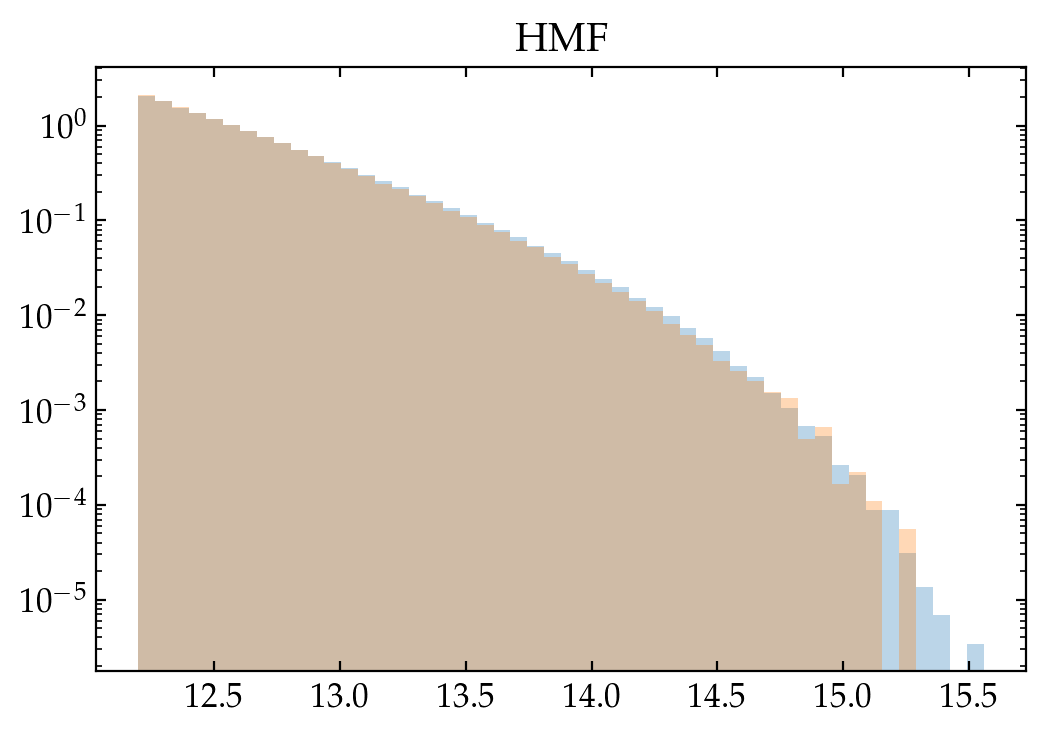

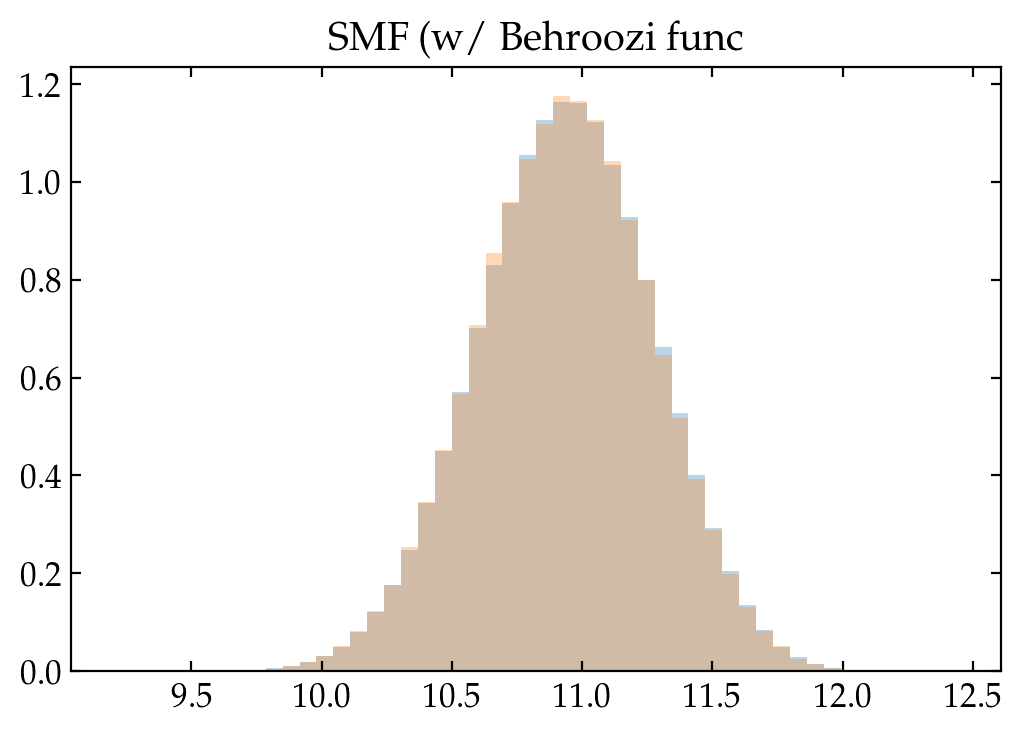

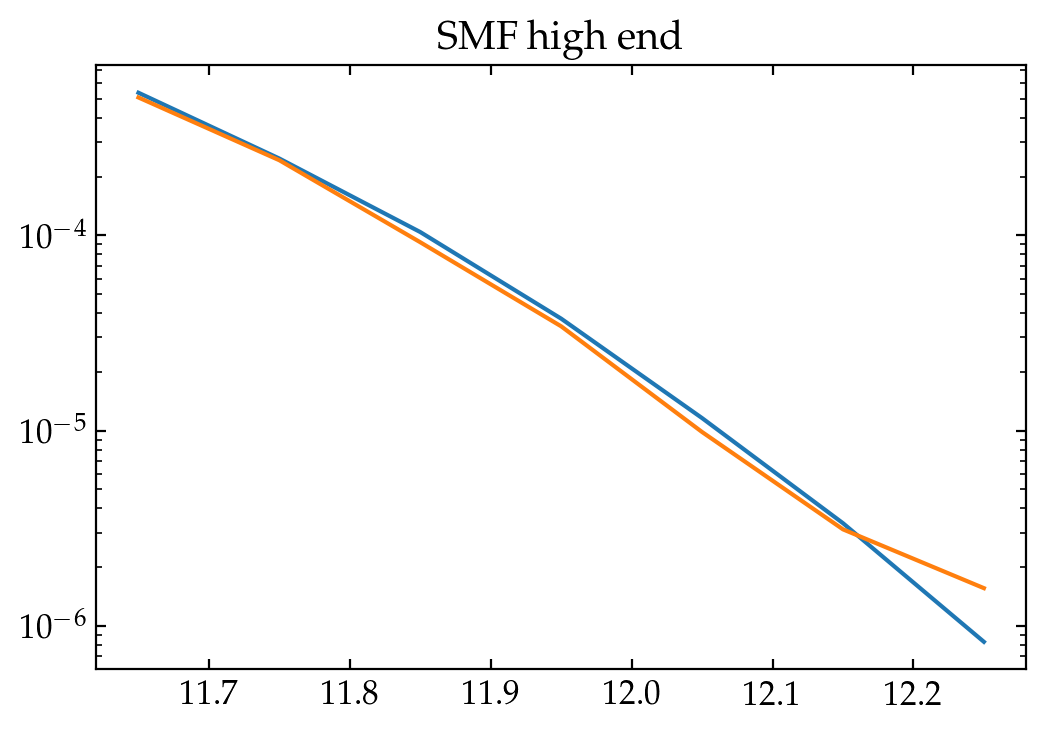

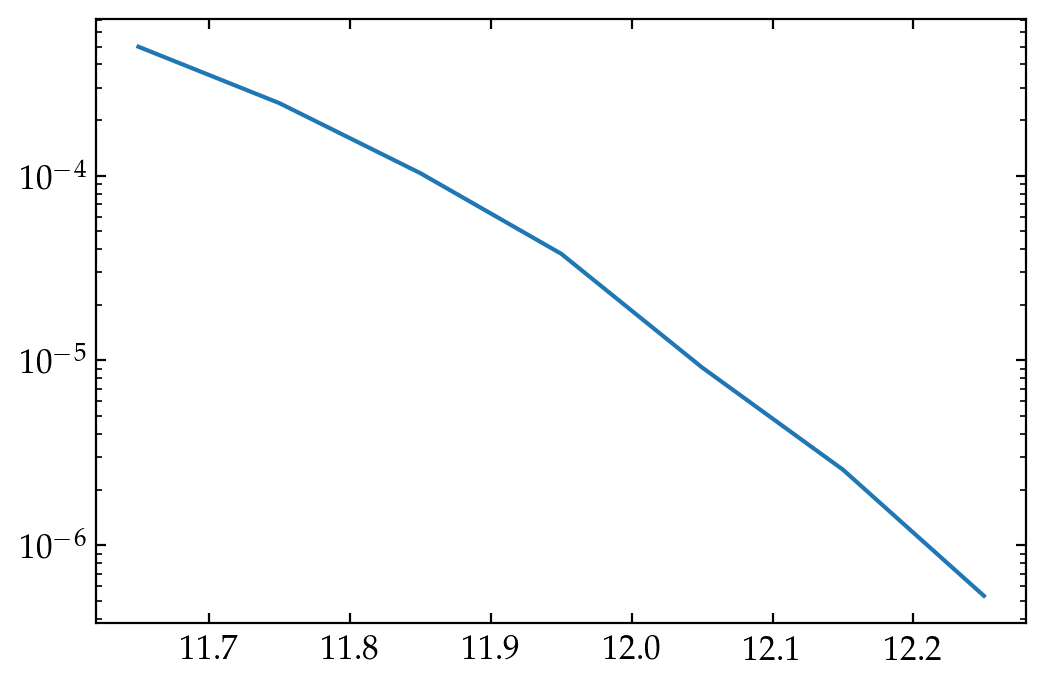

In [55]:
# Halo masses should be similar in smdpl and mdpl
mdpl, mdpl_size = d.load_mdpl()
smdpl, smdpl_size = d.load_smdpl()

_, ax = plt.subplots()
_, bins, _ = ax.hist(np.log10(mdpl["halo_mvir"]), bins=50, density=True, alpha=0.3)
ax.hist(np.log10(smdpl["halo_mvir"]), bins=bins, density=True, alpha=0.3)
ax.set(yscale="log", title="HMF")

# Stellar masses should be similar
mdpl_sm = get_sm_for_sim(mdpl, b_params, s_params)
smdpl_sm = get_sm_for_sim(smdpl, b_params, s_params)

_, ax = plt.subplots()
_, bins, _ = ax.hist(mdpl_sm, bins=50, density=True, alpha=0.3)
ax.hist(smdpl_sm, bins=bins, density=True, alpha=0.3)
ax.set(title="SMF (w/ Behroozi func)")

# The SMF should be similar
sm_bins = np.linspace(11.6, 12.3, 8)
sm_bin_centers = (sm_bins[:-1] + sm_bins[1:]) / 2

_, ax = plt.subplots()
ax.plot(sm_bin_centers, get_smf(mdpl_sm, sm_bins, mdpl_size**3))
ax.plot(sm_bin_centers, get_smf(smdpl_sm, sm_bins, smdpl_size**3))
ax.set(yscale="log", title="SMF high end")

# The ratio of the number of galaxies should be similar to the ratio of volumes
print(len(mdpl) / len(smdpl), mdpl_size**3 / smdpl_size**3)

# Smf should be quite a bit larger than 1e-4 at 11.6 (different to fig 4 https://arxiv.org/pdf/1707.01904.pdf)
_, ax = plt.subplots()
plt.plot(obs_smf["logm_mean"], obs_smf["smf"])
ax.set(yscale="log")

# Go from mass to Vmax

Per peter, Mpeak has too low clustering. We should instead be using Vmax at Mpeak. However we have no idea what the start point for Vmax@Mpeak should be...

## Option 1:
The log of the vmax and mpeak are linearly related. Just shift them to match. I think this is theoretically bad and while SMF fits clustering doesn't.

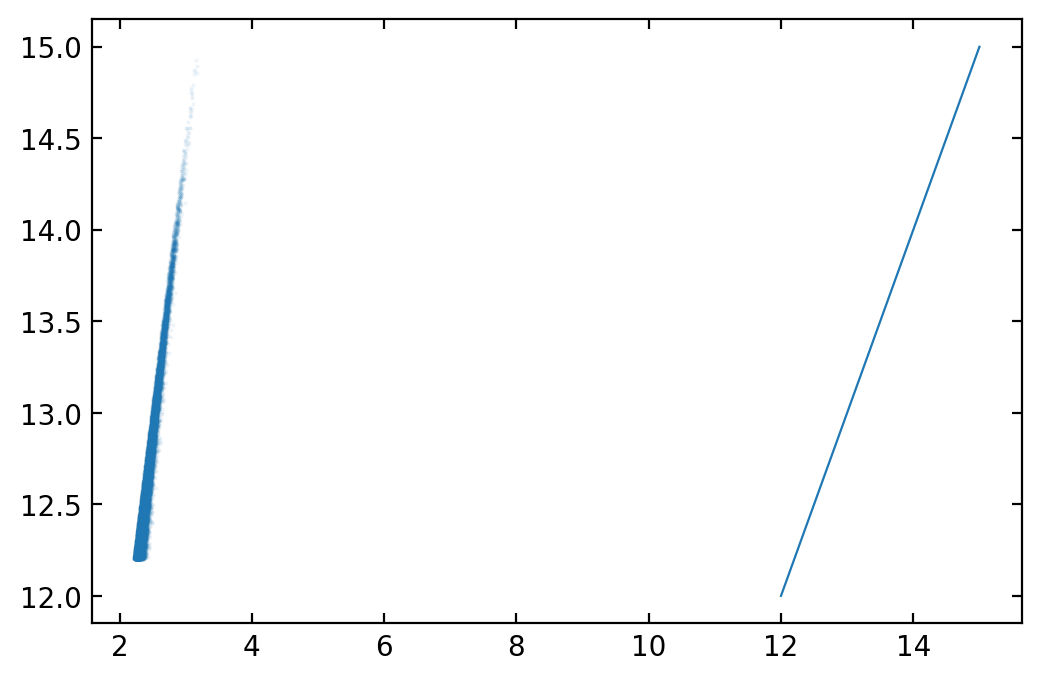

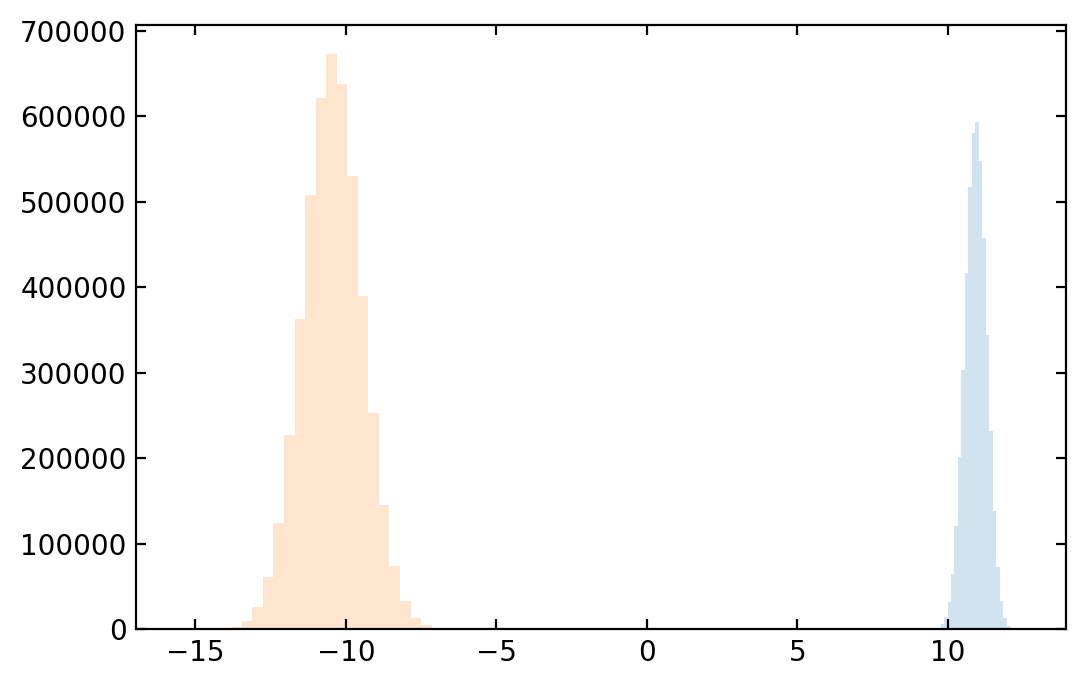

In [49]:
_, ax = plt.subplots()

ax.scatter(np.log10(sim_data["Vmax@Mpeak"][::ds]), np.log10(sim_data["halo_mvir"])[::ds], alpha=0.1, s=0.1)
ax.plot((12, 15), (12, 15))

# There was an optimizing fit in here which I have removed...
_, ax = plt.subplots()
for proxy in ["halo_mvir", "Vmax@Mpeak"]:
    log_stellar_masses = get_sm_for_sim(sim_data, mass_b_params, mass_s_params, proxy)
    ax.hist(log_stellar_masses, bins=30, alpha=0.2)

## Option 2:
Use the start point for mpeak find the stellar masses. Then work out the best fit to those stellar masses with Mpeak using the same function. And now you have your starting params!

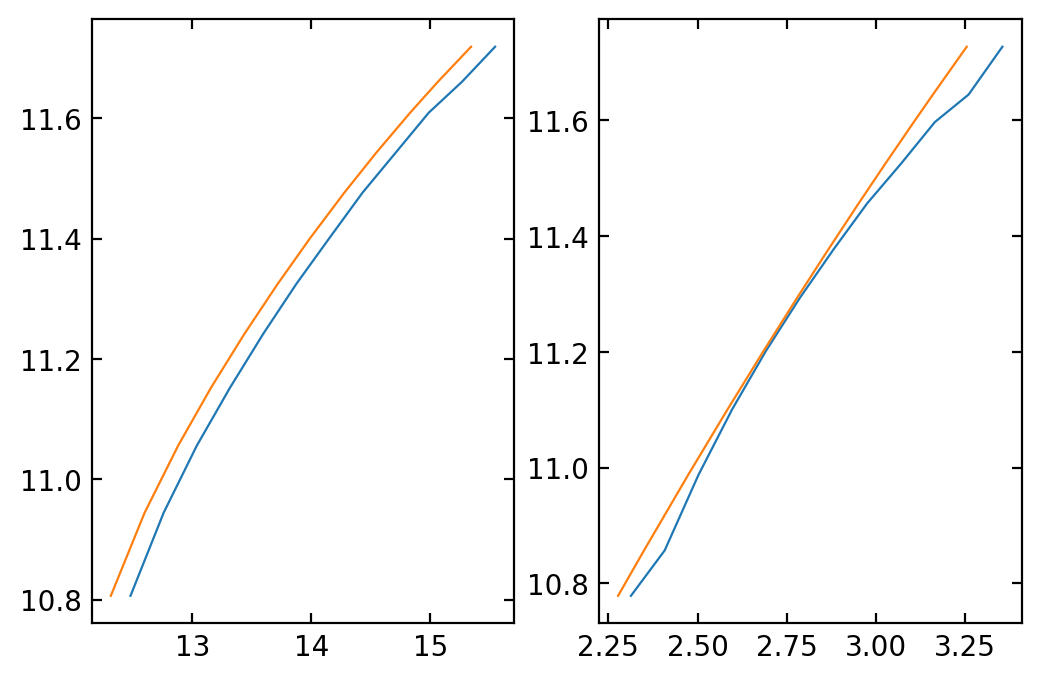

In [114]:
log_stellar_masses = get_sm_for_sim(sim_data, mass_b_params, mass_s_params, mass_x_field)

_, axes = plt.subplots(1, 2)

for i, (x_value, params) in enumerate([
    (mass_x_field, mass_b_params),
    (vmax_x_field, vmax_b_params),
]):
    sample_sm, bin_edges, _ = scipy.stats.binned_statistic(np.log10(sim_data[x_value]), log_stellar_masses, bins = 12)
    sample_x = bin_edges[:-1] + np.diff(bin_edges)[0]

    axes[i].plot(sample_x, sample_sm, label="data")
    
    model_x = smhm_fit.f_shmr_inverse(sample_sm, 10**params[0], 10**params[1], *params[2:])
    axes[i].plot(model_x, sample_sm, label="model")

### old

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]
/home/christopher/research/satellite_fraction/cb/smhm_fit/smhm_fit.py:97: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


'\ndef diff(p, sim_data):\n    print(p)\n    try:\n        _, _, pred_sm, _, _, _ = get_sm_for_sim(sim_data, p[:5], p[5:], "Vmax@Mpeak", sanity=True)\n    except ValueError:\n        return 1e10\n    err = np.sum(np.power(sample_sm - pred_sm, 2))\n    print(err)\n    return err\n\nres = scipy.optimize.minimize(\n    diff,\n    b_params_v + s_params_v,\n    args=(sim_data),\n    method="Nelder-Mead",\n)\n'

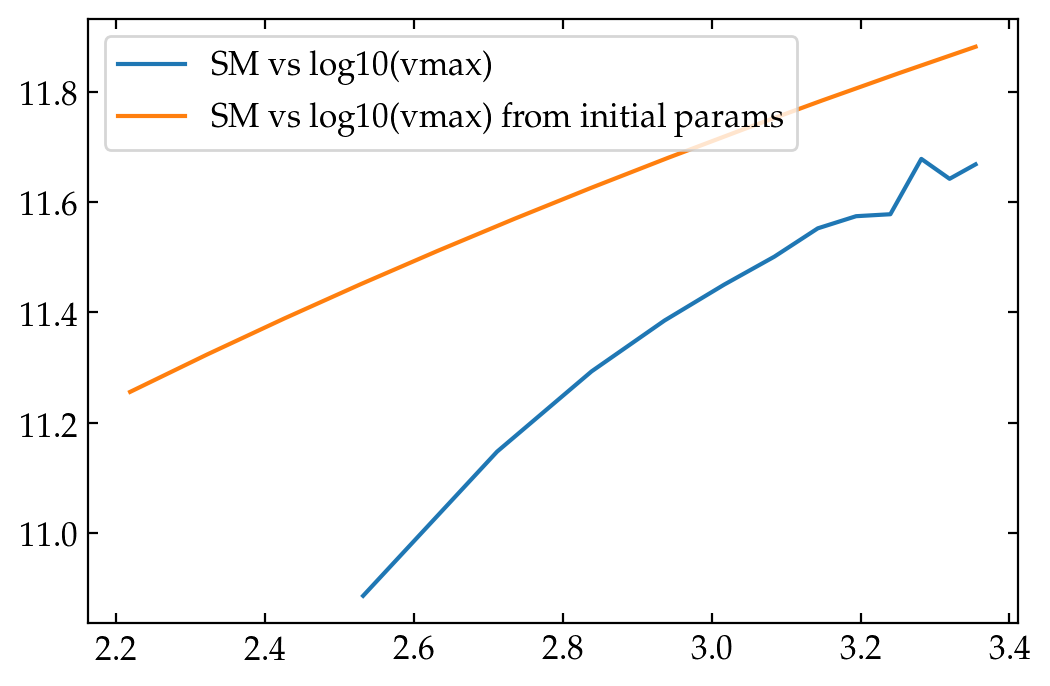

In [123]:
_, ax = plt.subplots()

# First just get the stellar masses using the best mass fit
best_mass_fit = [12.46178498, 10.87987102,  0.45690214,  0.636816,    1.87057079, -0.0614553,   1.07878507]
log_stellar_masses, sample_halo, sample_stellar, _, _, _ = get_sm_for_sim(sim_data, best_mass_fit[:5], best_mass_fit[5:], "halo_mvir")
#ax.plot(sample_halo, sample_stellar)

# Now bin those stellar masses by Vmax@Mpeak. We now have Vmax -> Stellar mass relation
sample_sm, bin_edges, _ = scipy.stats.binned_statistic(sim_data["Vmax@Mpeak"], log_stellar_masses, bins = 12)
sample_vmax = bin_edges[:-1] + np.diff(bin_edges)[0]

ax.plot(np.log10(sample_vmax), sample_sm, label="SM vs log10(vmax)")

# We want to find the 5 params + 2 scatter params that fit this vmax -> sm relation


log_stellar_masses, sample_vmax, sample_stellar, _, _, _ = get_sm_for_sim(sim_data, best_p[:5], best_p[5:] + np.array([1.5, 0]), "Vmax@Mpeak", sanity=True)
ax.plot(sample_vmax, sample_stellar, label="SM vs log10(vmax) from initial params")
ax.legend()
"""
_, ax = plt.subplots()
ax.hist(log_stellar_masses[log_stellar_masses > 11.6])
"""
"""
def diff(p, sim_data):
    print(p)
    try:
        _, _, pred_sm, _, _, _ = get_sm_for_sim(sim_data, p[:5], p[5:], "Vmax@Mpeak", sanity=True)
    except ValueError:
        return 1e10
    err = np.sum(np.power(sample_sm - pred_sm, 2))
    print(err)
    return err

res = scipy.optimize.minimize(
    diff,
    b_params_v + s_params_v,
    args=(sim_data),
    method="Nelder-Mead",
)
"""

# Find bestfit to SMF with optimizer

In [ ]:
cen_cuts = (11.65, 12.5)
sat_cuts = (11.55, 11.65)

obs_clust, obs_clust_err = c.compute_hsc_clustering(gals, cen_cuts, sat_cuts)

Randoms should be much longer that sample: 500000 1565 1708


/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/Corrfunc/mocks/DDrppi_mocks.py:348: UserWarning: One or more input array has non-native endianness!  A copy will be made with the correct endianness.
  warn('One or more input array has non-native endianness!  A copy will be made with the correct endianness.')


In [115]:
params = b_params + s_params

res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, cen_cuts, sat_cuts, x_field, 1),
    method="Nelder-Mead",
    tol=2,
)
assert res.success == True
best_fit = res.x

[ 2.4  10.91  0.6   0.2   0.2  -0.1   0.5 ]
115.1741608074347
[ 2.52 10.91  0.6   0.2   0.2  -0.1   0.5 ]
309.4964900481645
[ 2.4    11.4555  0.6     0.2     0.2    -0.1     0.5   ]
271235.5272188205
[ 2.4  10.91  0.63  0.2   0.2  -0.1   0.5 ]
126.81813930929316
[ 2.4  10.91  0.6   0.21  0.2  -0.1   0.5 ]
120.44426534579088
[ 2.4  10.91  0.6   0.2   0.21 -0.1   0.5 ]
118.84513128337818
[ 2.4   10.91   0.6    0.2    0.2   -0.105  0.5  ]
167.5323161031982
[ 2.4   10.91   0.6    0.2    0.2   -0.1    0.525]
26.17354659786258
[ 2.43428571 10.3645      0.60857143  0.20285714  0.20285714 -0.10142857  0.50714286]
416.8570199402684
[ 2.42571429 10.63725     0.60642857  0.20214286  0.20214286 -0.10107143  0.50535714]
403.690540828544
[ 2.40857143 11.18275     0.60214286  0.20071429  0.20071429 -0.10035714  0.50178571]
4354.939931698401
[ 2.42142857 10.773625    0.60535714  0.20178571  0.20178571 -0.10089286  0.50446429]
342.90875439266233
[ 2.41285714 11.046375    0.60321429  0.20107143  0.20107

2.0343014721391564


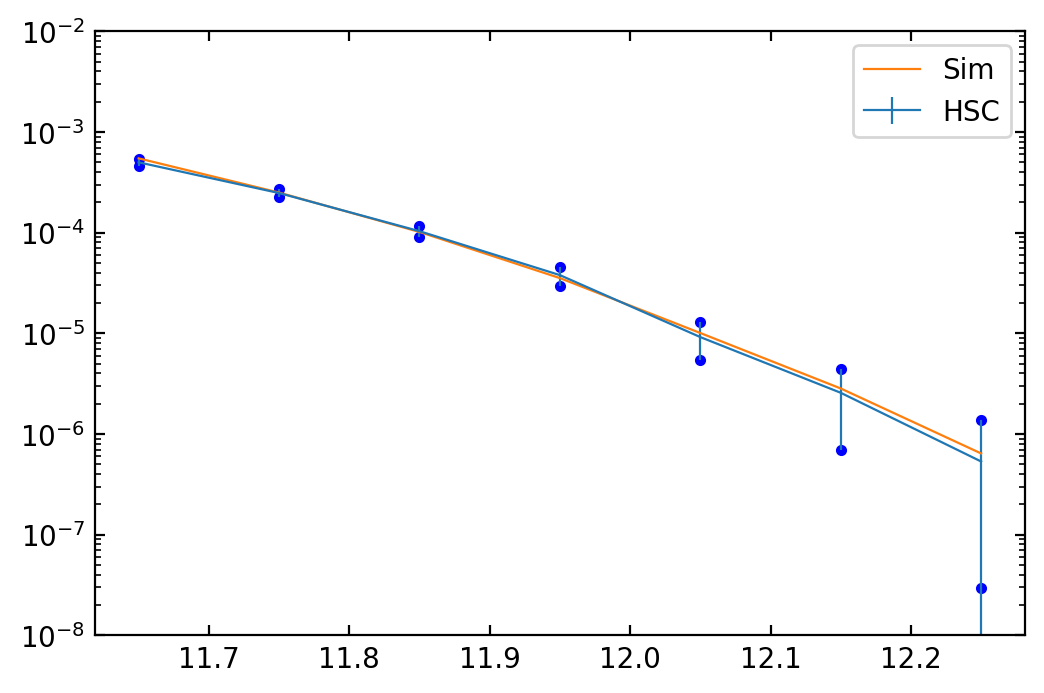

In [117]:
#ax = p.plot_smfs(sim_data, obs_smf, best_p[:5] + np.array([0.06, 0.1, 0.0001, 0.001, -0.4]), best_p[5:] + np.array([0.01, 0]), sim_size, "Vmax@Mpeak")
ax = p.plot_smfs(sim_data, obs_smf, best_fit[:5], best_fit[5:], sim_size, x_field)
ax.set(ylim=(1e-8, 1e-2));

# Compute and Compare Clustering

## In HSC

In [32]:
obs_clust, obs_clust_err = c.compute_hsc_clustering(gals, cen_cuts, sat_cuts, for_plot=True)

Randoms should be much longer that sample: 500000 1565 1708


## In the sim

In [118]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit[:5], best_fit[5:], x_field)
sim_clust, sim_clust_err  = c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, cen_cuts, sat_cuts)

Randoms len is 10x the data 775090


In [119]:
print(obs_clust)#, obs_clust_err)
print(sim_clust, sim_clust_err)

18.39904305036913
14.41478638948511 0.12249115916046094


## Tests

[None, Text(0.5, 1.0, 'The SMFs are the same (within a scaling factor)')]

/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


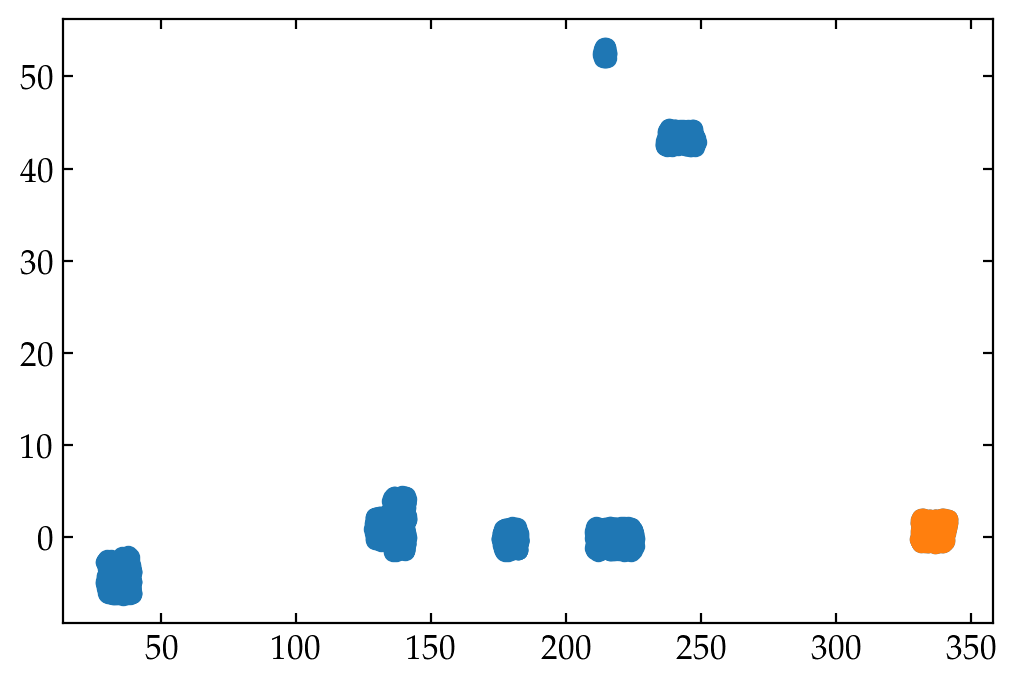

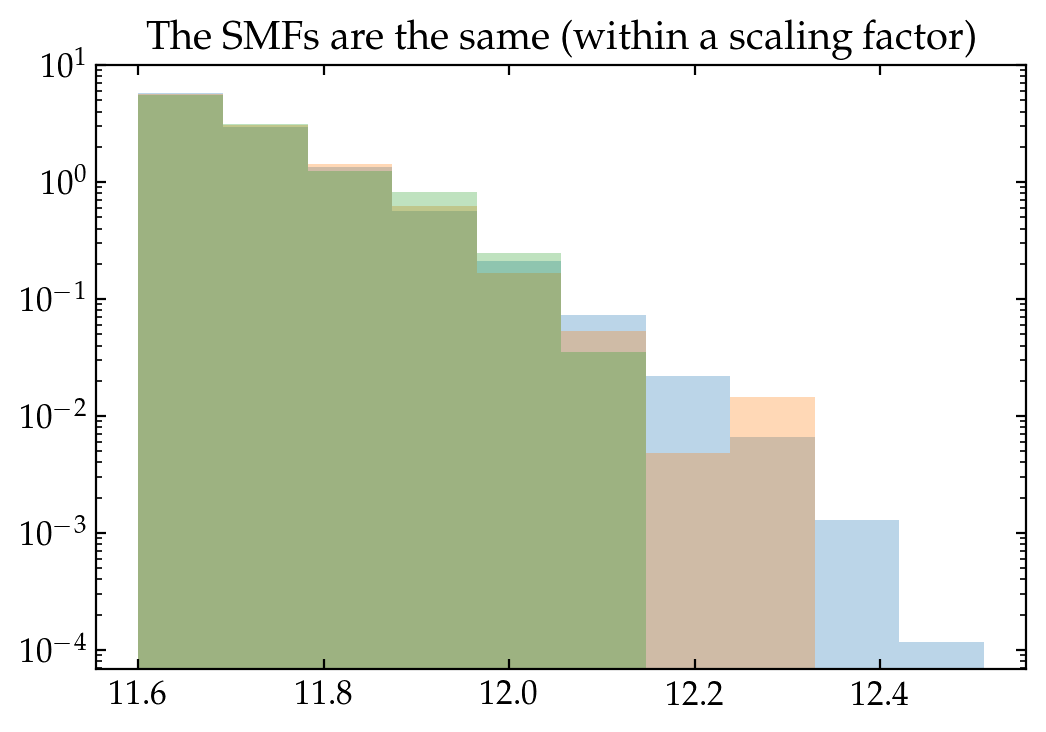

In [21]:
_, ax = plt.subplots()
ax.scatter(gals["ra"], gals["dec"])

ss_gals = gals[gals["ra"] > 300]
ax.scatter(ss_gals["ra"], ss_gals["dec"])

# Are the SMFs the same incl some multiplicative factor?
_, ax = plt.subplots()
_, bins, _ = ax.hist(log_stellar_masses[log_stellar_masses > 11.6], density=True, alpha=0.3)
ax.hist(gals["logm_max"][gals["logm_max"] > 11.6], density=True, bins=bins, alpha=0.3)
ax.hist(ss_gals["logm_max"][ss_gals["logm_max"] > 11.6], density=True, bins=bins, alpha=0.3)
ax.set(yscale="log", title="The SMFs are the same (within a scaling factor)")

No handles with labels found to put in legend.


310
93583
0.25033000111579895 0.4699699878692627
330.88113164799324 341.3245412233512
542.9176576001199 130.05682007678672 36.06198314682097 232.83135321096566 66.82396709626335
5067606.247991663


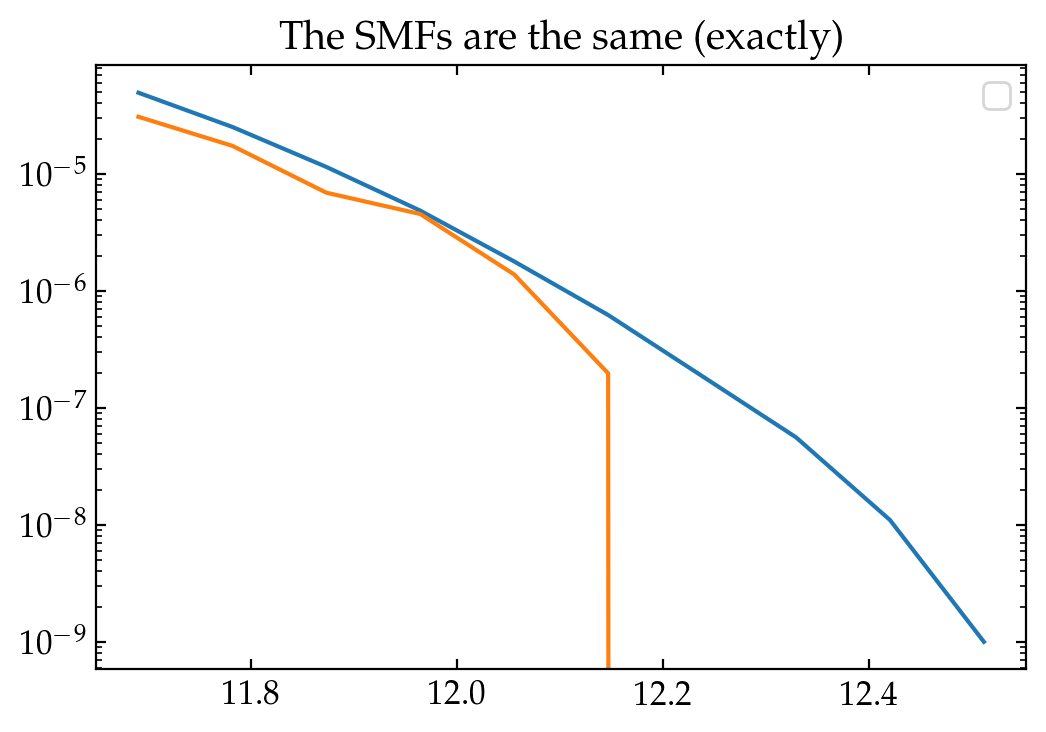

In [22]:
# How about exactly the same (need volume)
print(len(ss_gals[ss_gals["logm_max"] > 11.6]))
print(len(log_stellar_masses[log_stellar_masses > 11.6]))

min_z, max_z = np.min(ss_gals["z_best"]), np.max(ss_gals["z_best"])
min_ra, max_ra = np.min(ss_gals["ra"]), np.max(ss_gals["ra"])
min_dec, max_dec = np.min(ss_gals["dec"]), np.max(ss_gals["dec"])

print(min_z, max_z)
print(min_ra, max_ra)


from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology("planck18")
depth = cosmo.comovingDistance(min_z, max_z)
s_width = cosmo.angularDiameterDistance(min_z * (max_ra - min_ra) / 57)
s_height = cosmo.angularDiameterDistance(min_z * (max_dec - min_dec) / 57)

e_width = cosmo.angularDiameterDistance(max_z * (max_ra - min_ra) / 57)
e_height = cosmo.angularDiameterDistance(max_z * (max_dec - min_dec) / 57)

print(depth, s_width, s_height, e_width, e_height)
vol = depth * (s_width + e_width)/2 * (s_height + e_height)/2
print(vol)

# Are the SMFs the same incl some multiplicative factor?
_, ax = plt.subplots()

count_sim, bins = np.histogram(log_stellar_masses[log_stellar_masses > 11.6])
count_sim =  count_sim / sim_size**3
count_hsc, _ = np.histogram(ss_gals["logm_max"][ss_gals["logm_max"] > 11.6], bins=bins)
count_hsc = count_hsc / vol

ax.plot(bins[:-1] + np.diff(bins)[0], count_sim)
ax.plot(bins[:-1] + np.diff(bins)[0], count_hsc)
ax.set(yscale="log", title="The SMFs are the same (exactly)")
ax.legend()

# Cluster finder